In [413]:
# Scipy imports
import scipy.io as sio
from scipy.fft import fft, fftfreq

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Selecting Patient Dataset

I've downloaded the following patient data and I have also its quality:
- `S1.mat` $\rightarrow$ good patient data
- `S3.mat` $\rightarrow$ good patient data
- `S31.mat` $\rightarrow$ good patient data
- `S32.mat` $\rightarrow$ good patient data
- `S19.mat` $\rightarrow$ medium patient data
- `S29.mat` $\rightarrow$ bad patient data

In [414]:
subject = 1
eeg_raw_data = sio.loadmat(f'data/S{subject}.mat')['data']

show_feature_matrix = False

print(eeg_raw_data.shape)

(64, 1500, 40, 6)


## Filtering with CAR

In [415]:
number_of_trials = eeg_raw_data.shape[3]
number_of_frequencies = eeg_raw_data.shape[2]

# Applying CAR filter to all trials and frequencies
eeg_filtered_data = np.zeros(eeg_raw_data.shape)
for trial in range(number_of_trials):
    for freq in range(number_of_frequencies):
        trial_frequency_data = np.array(eeg_raw_data[:, :, freq, trial])
        car_mean = np.mean(trial_frequency_data, axis=0)
        eeg_filtered_data[:, :, freq, trial] = trial_frequency_data - car_mean

## CAR Filter Applied to Patient Dataset

In [416]:
trial = 0
freq = 0 # 8 Hz

useful_data = np.array(eeg_raw_data[:, 125:1375, freq, trial])

electrodes_indexes = {"O1": 60, "Oz": 61, "O2": 62}

samples = 1250
spacing = 4
time_range = np.linspace(0, samples * spacing, samples)
freq_range = fftfreq(samples, spacing)[: samples // 2] * 1000

### Applying CAR filter

In [418]:
# applying CAR filter
o1_values = useful_data[electrodes_indexes['O1'], :]
oz_values = useful_data[electrodes_indexes['Oz'], :]
o2_values = useful_data[electrodes_indexes['O2'], :]

car_mean = np.mean(useful_data, axis=0)

electrodes_df = pd.DataFrame({
  'O1': o1_values - car_mean,
  'Oz': oz_values - car_mean,
  'O2': o2_values - car_mean,
  'Time (ms)': np.linspace(0, samples * spacing, samples)
})

electrodes_df.head()

,O1,Oz,O2,Time (ms)
0,2.502012,1.846361,2.403412,0.000000
1,-0.893254,-0.734012,-0.410190,4.003203
2,-0.381330,-0.464213,0.032789,8.006405
3,-3.046966,-2.806916,-1.653966,12.009608
4,-3.915558,-3.756761,-2.877666,16.012810


In [419]:
fft_electrodes_df = pd.DataFrame({
  'O1': 2/samples * np.abs(fft(np.array(electrodes_df['O1']))[0:samples//2]),
  'Oz': 2/samples * np.abs(fft(np.array(electrodes_df['Oz']))[0:samples//2]),
  'O2': 2/samples * np.abs(fft(np.array(electrodes_df['O2']))[0:samples//2]),
  'Frequency (Hz)': freq_range
})

print(fft_electrodes_df.columns.values)
fft_electrodes_df.head()

['O1' 'Oz' 'O2' 'Frequency (Hz)']


,O1,Oz,O2,Frequency (Hz)
0,0.378251,0.316406,0.088819,0.0
1,1.579619,1.826312,1.421343,0.2
2,1.238262,2.371483,1.045069,0.4
3,1.503814,1.708234,0.561514,0.6
4,2.477595,1.925787,2.922226,0.8


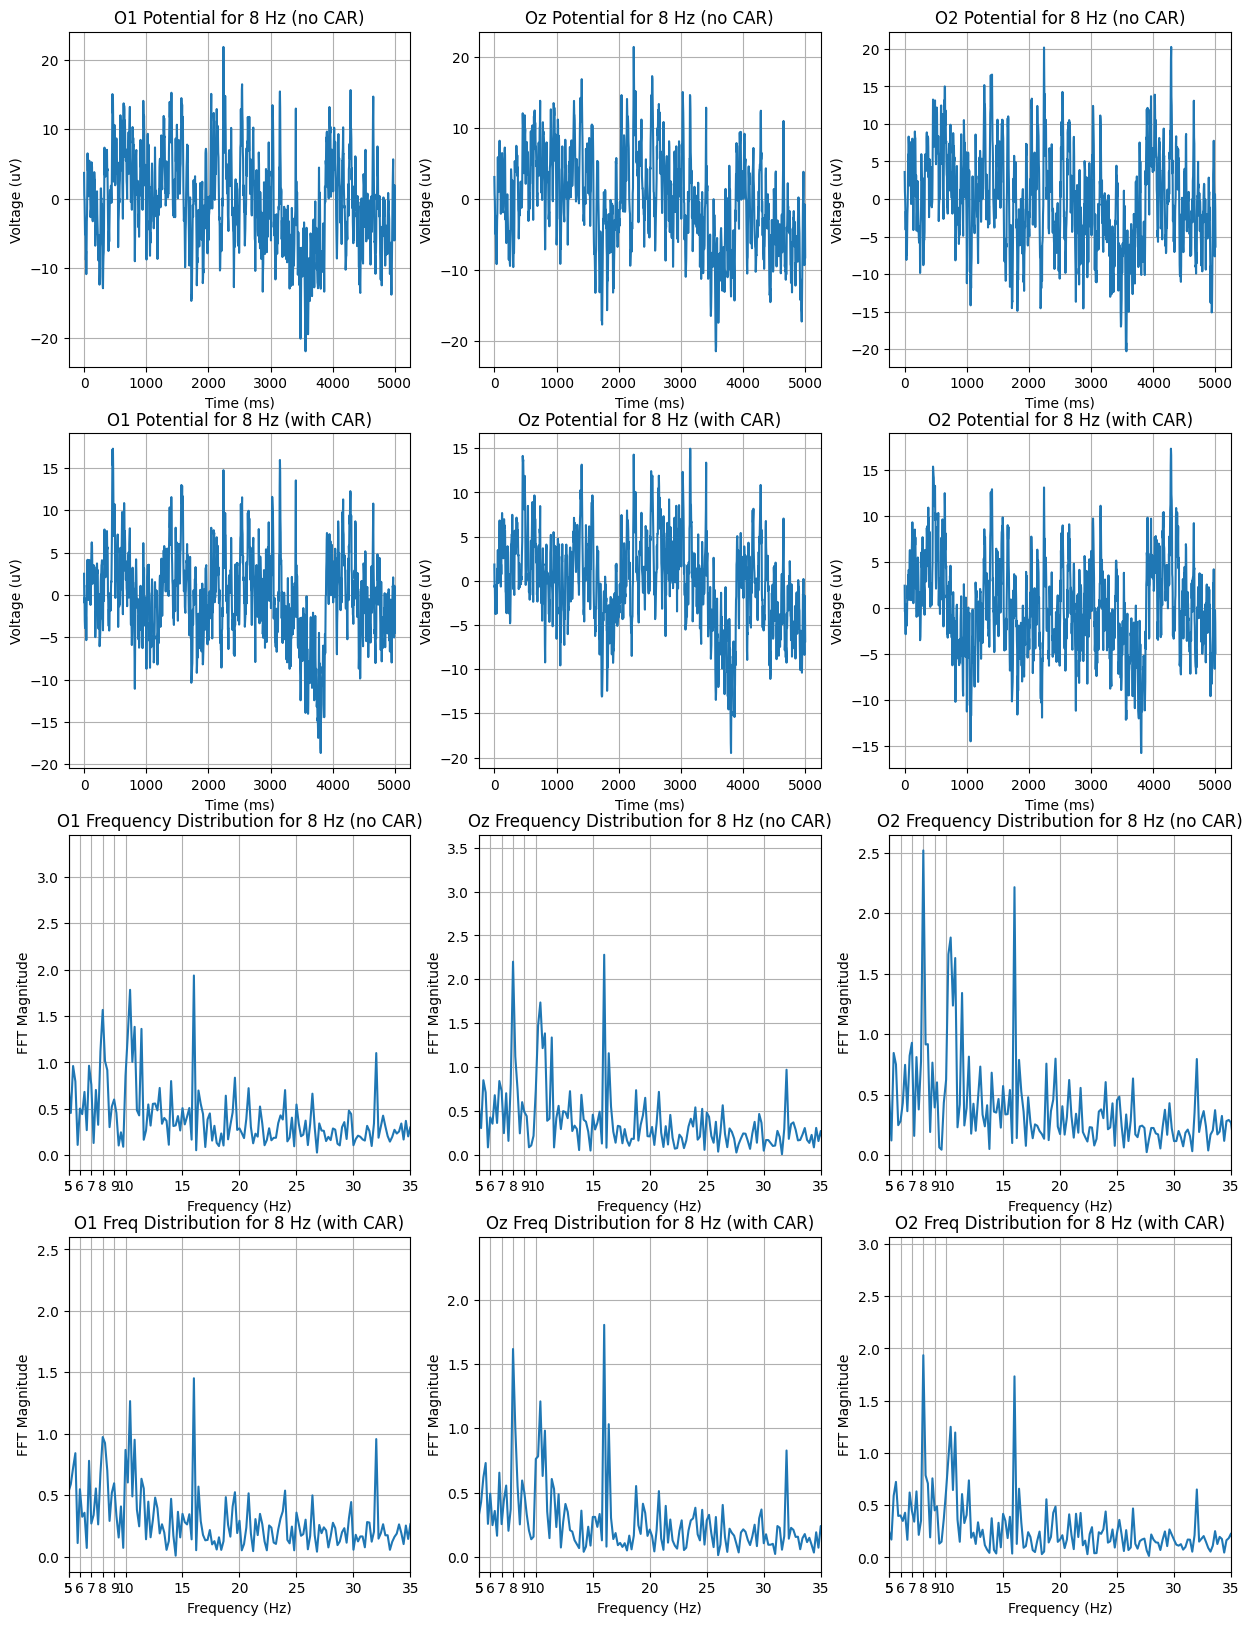

In [420]:
fig, axes = plt.subplots(4, len(electrodes_indexes.values()), figsize=(15, 20))

for i, electrode in enumerate(electrodes_indexes):
    electrode_index = electrodes_indexes[electrode]
    electrode_data = useful_data[electrode_index, :]
    electrode_fft = 2 / samples * np.abs(fft(electrode_data)[0 : samples // 2])

    axes[0, i].set_title(f"{electrode} Potential for 8 Hz (no CAR)")
    axes[0, i].plot(time_range, electrode_data)
    axes[0, i].set_xlabel("Time (ms)")
    axes[0, i].set_ylabel("Voltage (uV)")
    axes[0, i].grid()

    axes[2, i].set_title(f"{electrode} Frequency Distribution for 8 Hz (no CAR)")
    axes[2, i].plot(freq_range, electrode_fft)
    axes[2, i].set_xticks(np.hstack((np.arange(0, 100, 5), np.arange(5, 10, 1))))
    axes[2, i].set_xlim(5, 35)
    axes[2, i].set_xlabel("Frequency (Hz)")
    axes[2, i].set_ylabel("FFT Magnitude")
    axes[2, i].grid()

for i, column in enumerate(electrodes_df.columns.values):
  if column == 'Time (ms)':
    continue
  axes[1, i].set_title(f'{column} Potential for 8 Hz (with CAR)')
  axes[1, i].plot(electrodes_df['Time (ms)'], electrodes_df[column])
  axes[1, i].set_xlabel('Time (ms)')
  axes[1, i].set_ylabel('Voltage (uV)')
  axes[1, i].grid()
  
for i, column in enumerate(fft_electrodes_df.columns.values):
  if column == 'Frequency (Hz)':
    continue
  axes[3, i].set_title(f'{column} Freq Distribution for 8 Hz (with CAR)')
  axes[3, i].plot(fft_electrodes_df['Frequency (Hz)'], fft_electrodes_df[column])
  axes[3, i].set_xticks(np.hstack((np.arange(0, 100, 5), np.arange(5, 10, 1))))
  axes[3, i].set_xlim(5, 35)
  axes[3, i].set_xlabel('Frequency (Hz)')
  axes[3, i].set_ylabel('FFT Magnitude')
  axes[3, i].grid()


# Feature Extraction

- Selected frequencies for feature extraction phase: 8 Hz (0), 10 Hz (2), 12 Hz (4) and 15 Hz (7)
- Each frequency will have 5 windows of data (1s wide) to each of the 6 trials
- Also we will get the magnitude on the first harmonic for each frequency

## Creating Label Vectors

In [421]:
# Data from frequency mapping
freq_phase_file = 'data/freq_phase.mat'
freq_phase = sio.loadmat(freq_phase_file)

freq_mapping = freq_phase['freqs'][0]
freq_mapping = {round(value, 1): idx for idx, value in enumerate(freq_mapping)}

print(freq_mapping)

{8.0: 0, 9.0: 1, 10.0: 2, 11.0: 3, 12.0: 4, 13.0: 5, 14.0: 6, 15.0: 7, 8.2: 8, 9.2: 9, 10.2: 10, 11.2: 11, 12.2: 12, 13.2: 13, 14.2: 14, 15.2: 15, 8.4: 16, 9.4: 17, 10.4: 18, 11.4: 19, 12.4: 20, 13.4: 21, 14.4: 22, 15.4: 23, 8.6: 24, 9.6: 25, 10.6: 26, 11.6: 27, 12.6: 28, 13.6: 29, 14.6: 30, 15.6: 31, 8.8: 32, 9.8: 33, 10.8: 34, 11.8: 35, 12.8: 36, 13.8: 37, 14.8: 38, 15.8: 39}


In [422]:
windows = 5
trials = 6

# selected_frequencies = {
#     8: 0, 10: 2, 12: 4, 15: 7
# }

selected_frequencies = {int(key): value for key, value in freq_mapping.items() if key.is_integer()}

print(f"Selected frequencies: {selected_frequencies}")

Selected frequencies: {8: 0, 9: 1, 10: 2, 11: 3, 12: 4, 13: 5, 14: 6, 15: 7}


(240, 8)


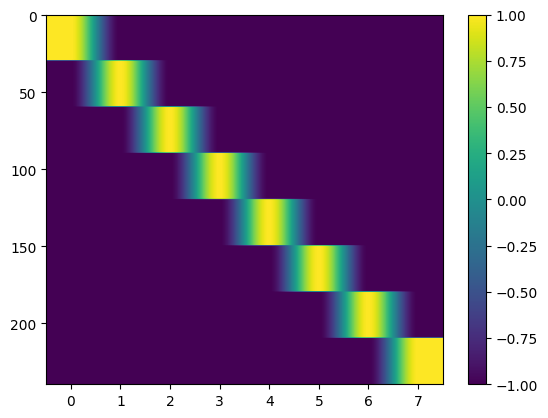

In [423]:
Y = np.ones((windows * trials * len(selected_frequencies), len(selected_frequencies)), int)

for i in range(windows * trials * len(selected_frequencies)):
    for j in range(len(selected_frequencies)):
        if int(i / (windows * trials)) != j:
            Y[i, j] *= -1

# print("\nY: ", Y)
print(Y.shape)
plt.imshow(Y, aspect='auto')
plt.colorbar()
plt.show()

## Creating Feature Matrix

In [424]:
selected_channels = {
    "POz": 55,
    "O1": 60,
    "Oz": 61,
    "O2": 62,
}

selected_eeg_data = eeg_filtered_data
number_of_channels = len(selected_channels)
selected_channel_indices = list(selected_channels.values())

windowed_data = np.split(
    selected_eeg_data[selected_channel_indices, 125:1375, :, :], indices_or_sections=windows, axis=1
)
print('Windowed data:', np.array(windowed_data).shape)

Windowed data: (5, 4, 250, 40, 6)


In [427]:
select_first_harmonic = True
number_of_frequencies = len(selected_frequencies) * (2 if select_first_harmonic else 1)

# create a first line for vstack
# each column is a channel for a frequency and each row is a trial for a window
# k is the window, j is the trial, i is the frequency, l is the channel

X = np.array(
    [
        np.zeros(
            number_of_channels
            * number_of_frequencies
        )
    ]
)

frequency_values_to_select = list(selected_frequencies.keys())
if select_first_harmonic: # append the first harmonic
    frequency_values_to_select = np.hstack(
        (frequency_values_to_select, np.array(frequency_values_to_select) * 2)
    )

for i, frequency in enumerate(selected_frequencies.values()):
    for j in range(trials):
        for k in range(windows):
            temp = np.array([])
            for l in range(number_of_channels):
                channel_data = windowed_data[k][l, :, frequency, j]
                channel_fft = np.abs(fft(channel_data))
                # temp = np.hstack((temp, channel_fft[list(selected_frequencies.keys())]))
                temp = np.hstack((temp, channel_fft[frequency_values_to_select]))
            X = np.vstack((X, temp))

# drop the first line
X = X[1:, :]

print(X.shape)

(240, 64)


In [428]:
# show feature matrix if needed
show_feature_matrix = False
if show_feature_matrix:
    fig, axes = plt.subplots(
        number_of_channels, number_of_frequencies, figsize=(30, 20),
    )

    for i in range(number_of_channels * number_of_frequencies):
        channel_name = list(selected_channels.keys())[i // number_of_frequencies]
        frequency = list(selected_frequencies.keys())[i % number_of_frequencies]
        axes[i // number_of_frequencies, i % number_of_frequencies].set_title(
            f"Channel {channel_name} on frequency {frequency} Hz"
        )
        axes[i // number_of_frequencies, i % number_of_frequencies].stem(X[:, i])
        axes[i // number_of_frequencies, i % number_of_frequencies].set_xlabel(
            "Line Index"
        )
        axes[i // number_of_frequencies, i % number_of_frequencies].set_ylabel(
            "FFT Magnitude"
        )
        axes[i // number_of_frequencies, i % number_of_frequencies].set_xticks(
            np.arange(0, windows * trials * number_of_frequencies, 5)
        )
        axes[i // number_of_frequencies, i % number_of_frequencies].grid()
    plt.suptitle("Feature Matrix by Column", fontsize=20)
    plt.subplots_adjust(hspace=0.7)
    plt.show()

In [429]:
Y = (Y + 1)/2

## Dividing train and validation data

In [430]:
print("X: ", X.shape)
print("Y: ", Y.shape)

X:  (240, 64)
Y:  (240, 8)


In [431]:
X[0]

array([137.46520495,  67.68195474,  85.02428584, 105.68924424,
        73.76822683,  65.99262785,  18.95813608,  71.40109441,
       252.92922455,  55.01380557,  32.97064743,  24.0434364 ,
        88.98537357,  38.1877453 ,  23.29626975,  14.82793774,
       192.31882549,  57.73732584, 129.60639436, 115.3079374 ,
       142.83862655,  91.19065339,  65.37887807, 120.62522197,
       191.35501551,  58.53380074,   9.27512027,  99.91834456,
       149.92935847,  25.70155382,  58.35897062,  33.82672028,
       130.7770844 ,  48.59923395, 114.57887032, 107.87212506,
       111.09124061,  92.44451037,  38.06971654,  51.44915532,
       257.85656973,  55.0308137 ,  14.54529436,  40.44244585,
       134.2827768 ,  24.83103364,  42.23290222,  18.09527898,
       126.17663136,  58.9769297 , 103.57095852, 121.29062461,
       129.62464904,  43.61299461,  19.42629039,  79.65334216,
       214.64418713,  62.46003163,  23.70620463,  31.66160059,
       108.08743627,  23.45878126,  34.47590444,  21.06

In [432]:
Y[0]

array([1., 0., 0., 0., 0., 0., 0., 0.])

In [433]:
# Divisão dos dados
X_training, X_validation, Y_training, Y_validation, = train_test_split(
    X, Y, test_size=0.2, stratify=Y
)

# Verificação das dimensões
print(f"Treinamento: {X_training.shape}, Validação: {X_validation.shape}")

print("X Validation:", X_validation.shape)
print("Y Validation:", Y_validation.shape)

print("X Training:", X_training.shape)
print("Y Training:", Y_training.shape)

Treinamento: (192, 64), Validação: (48, 64)
X Validation: (48, 64)
Y Validation: (48, 8)
X Training: (192, 64)
Y Training: (192, 8)


## Normalizing the training data

In [434]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_training = scaler.fit_transform(X_training)
X_validation = scaler.transform(X_validation)

# Classifing with MLP

In [449]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU


keras.backend.clear_session()

model = Sequential()
model.add(Dense(32, input_dim = X_training.shape[1], activation='relu')),
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(Y_training.shape[1], activation='softmax'))

optimizer = Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor = 'val_loss',  # Monitor validation loss
    patience = 10,         # Stop after 10 epochs of no improvement
    restore_best_weights = True  # Restore the best weights
)

history = model.fit(
    X_training, 
    Y_training, 
    epochs = 200, 
    batch_size = 8,
    callbacks = [early_stopping],
    validation_data = (X_validation, Y_validation)
)

Epoch 1/200


/home/fbaltor/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1380 - loss: 2.2202 - val_accuracy: 0.1875 - val_loss: 2.0479
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1707 - loss: 2.0529 - val_accuracy: 0.2292 - val_loss: 1.9292
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2972 - loss: 1.8895 - val_accuracy: 0.2083 - val_loss: 1.8260
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4390 - loss: 1.7525 - val_accuracy: 0.3958 - val_loss: 1.7155
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3510 - loss: 1.7458 - val_accuracy: 0.4167 - val_loss: 1.6019
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5203 - loss: 1.5191 - val_accuracy: 0.4167 - val_loss: 1.5052
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4662 - loss: 1.4587 - val_accuracy: 0.4583 - val_loss: 1.3970
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6056 - loss: 1.2845 - val_accuracy: 0.4792 - val_loss: 1.3

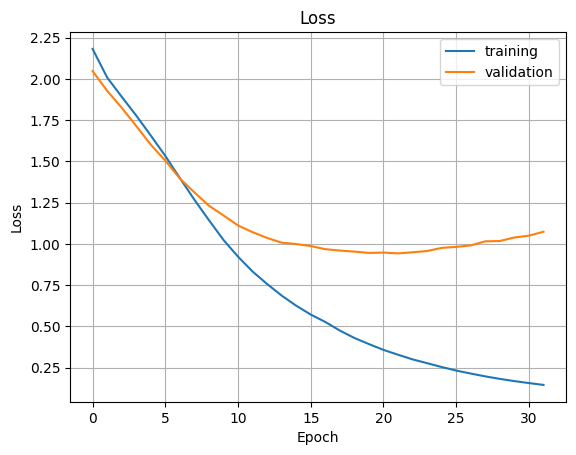

In [450]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.grid()
plt.show()

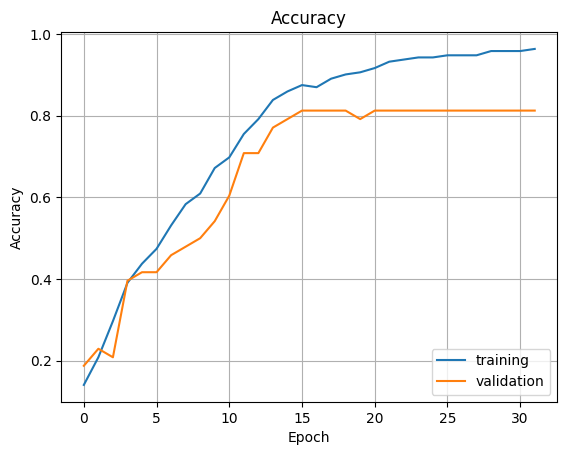

In [451]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='lower right')
plt.grid()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


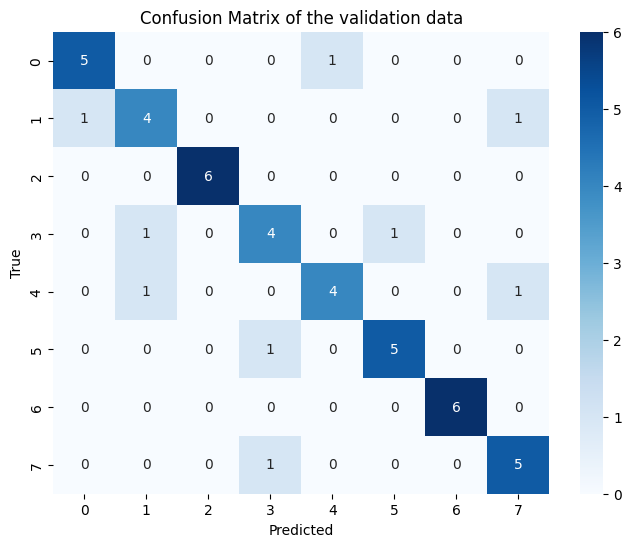

In [453]:
# Assuming model is already trained and X_test, y_test are the test data
y_pred_prob = model.predict(X_validation)  # Get the predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Get the predicted class labels

y_true = np.argmax(Y_validation, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of the validation data')
plt.show()
